# 목적: Cube 문서 제목들을 기준으로 가장 비슷한 문서 제목들끼리 자동으로 클러스터링 하기
# Goal: Automation of sentence clustering based on subjects of documents

In [ ]:
%matplotlib inline
from konlpy.tag import Kkma
from ckonlpy.tag import Twitter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import countVectorizer
from sklearn.preprocessing import noramlize
from datetime import date
import numpy as np
import pandas as pd
import operator
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.herarchy import ward, dendrogram,linkage
from sklearn.metrics import silhouette_samples

In [ ]:
from matplotlib import font_manager, rc
font_name=font_manager.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
rc('font',family=font_name)

In [ ]:
### 이미지1
filename='./Data(Pagerank)/INPUT/그룹웨어정리_2018.csv'
filename2='./Data(Pagerank)/INPUT/그룹웨어정리_2019.csv'

df_cube=pd.read_csv(filename,error_bad_lines=False,encoding='cp949',engine='python')
df_cube2=pd.read_csv(filename2,error_bad_lines=False,encoding='cp949',engine='python')
df_cube_all=pd.concat([df_cube,df_cube2])

df_cube_rev=pd.DataFrame()
df_cube_rev['COMP_CODE']=df_cube_all['PROCINST_COMP_CODE'].fillna('')
df_cube_rev['FORM_CODE']=df_cube_all['FORM_DESC'].fillna('')
df_cube_rev['DEPT_CODE']=df_cube_all['CUBE_DEPT_CODE'].fillna('')
df_cube_rev['CUBE_text']=df_cube_all['PROCINST_SUBJECT'].fillna('')
df_cube_rev['DATE']=df_cube_all['PROCINST_CREATE_DATE'].fillna('')
df_cube_rev.head()

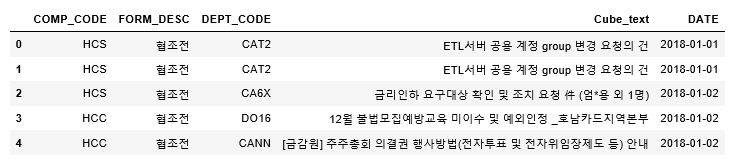

In [ ]:
### 이미지2
df_TRkeywords=pd.read_csv('./Data(Pagerank)/OUTPUT/cube_dept_keywords.csv',encoding='cp949')
del df_TRkeywords['Unnamed: 0']
df_TRkeywords

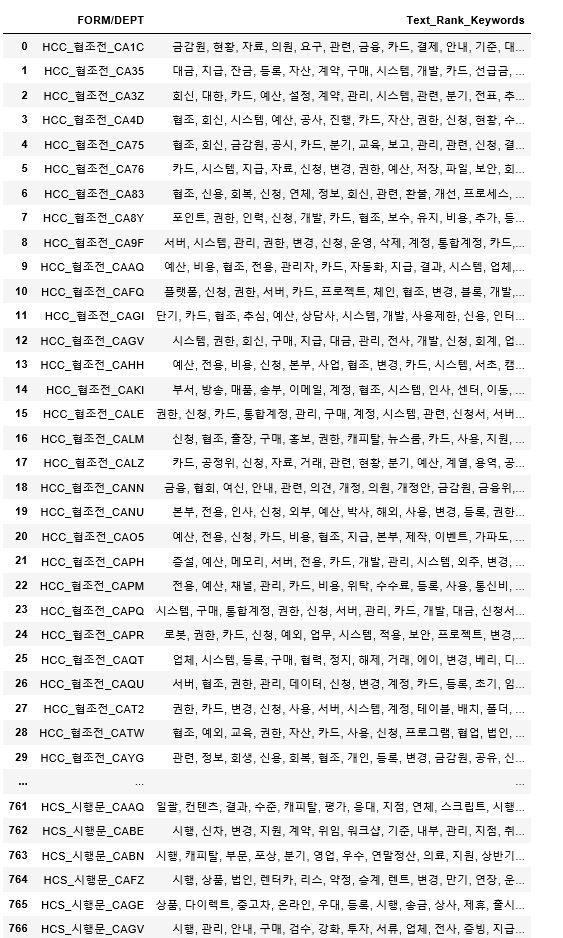

## Sentence Clustering

In [ ]:
### 이미지3, 이미지4
for dept in range(np.size(df_TRkeywords,axis=0)):
    target_code1=df_TRkeywords.iloc[dept,0].split('_')[0]
    target_code2=df_TRkeywords.iloc[dept,0].split('_')[2]
    target_code3=df_TRkeywords.iloc[dept,0].split('_')[1]
    df_tfidf=pd.read_csv('./Data/INPUT/tfidf/'+target_code1+'_'+target_code2+'_'+target_code3+'_월별_tfidf.csv',
                        encoding='cp949',engine='python')
    del df_tfidf['Unnamed: 0']
    topnwords=df_tfidf.shape[0]
    keyword_list=np.array([])
    for i in range(topnwords):
        for j in range(len(df_tfidf.columns)):
            if float(df_tfidf.iloc[i,j].split(': ')[1])<0.1:
                continue
            if df_tfidf.iloc[i,j].split(': ')[1]=='0.0':
                continue
            if df_tfidf.iloc[i,j].split(': ')[0] not in keyword_list:
                keyword_list=np.append(keyword_list,df_tfidf.iloc[i,j].split(': ')[0])
        if len(keyword_list)>349:
            break
    df_temp1=df_cube_rev[df_cube_rev['COMP_CODE']==target_code1].copy()
    df_temp2=df_temp1[df_temp1['DEPT_CODE']==target_code2].copy()
    df_temp3=df_temp2[df_temp2['FORM_DESC']==target_code3].copy()
    
    df_temp3=df_temp3.reset_index()
    del df_temp3['index']
    
    sentence_all=df_temp3.Cube_text.copy()
    
    freqMat=np.zeros((np.size(sentence_all),np.size(keyword_list)),dtype=float)
    for i,ii in enumerate(sentence_all):
        forj,jj in enumerate(keyword_list):
            if ii.__contains__(jj):
                freqMat[i,j]+=np.size(ii.split(jj))-1
                
    dist=1-cosine_similarity(freqMat[:,:])
    # ward linkage
    linkage_matrix=ward(dist)
    # single linkage
#     linkage_matrix=linakge(dist,'single')
    
    ddata=dendrogram(linkage_matrix,orientation='left',no_plot=True);
    ivl=np.array(ddata['ivl'])
    
    
    cluster_iter=200
    silhouette_result=np.zeros((cluster_iter,len(df_temp3)))
    y_hier_result=np.zeros((cluster_iter,len(df_temp3)))
    ivl_part_result=np.zeros((cluster_iter,len(df_temp3)),dtype=int)
    silhouette_score=np.zeros((cluster_iter,3))
    
    for n_cluster in range(2,cluster_iter):
        if n_cluster%10==0:
            print(n_cluster)
        ddata_part=dendrogram(linkage_matrix,orientation='left',
                             p=n_cluster, truncate_mode='lastp',
                              show_leaf_counts=True,
                              show_contracted=True,
                              no_plot=True)
        
        ivl_part=[]
        for x in np.array(ddata_part['ivl']):
            if x.__contains__('('):
                ivl_part.append(int(x.split('(')[1].split(')')[0]))
            else:
                ivl_part.append(1)
        st=0
        y_hier=np.zeros(np.size(ivl))
        for i in range(n_cluster):
            y_hier[[int(x) for x in ivl][st:st+ivl_part[i]]]=i
            st+=ivl_part[i]
        y_hier_result[n_cluster]=y_hier.copy()
        silhouette_result[n_cluster]=silhouette_samples(freqMat,y_hier,metric='cosine')
        ivl_part_result[n_cluster,:len(ivl_part)]=ivl_part.copy()
        
        
    # 실루엣 스무딩 (Silhouette smoothing)
    mw_silhouette_result=[]
    mw_size=5
    for i in range(2,cluster_iter-mw_size):
        mw_silhouette_result.append(np.max(silhouette_result[i:i+mw_size])-np.min(silhouette_result[i:i+mw_size]))
    cluster_val=(np.argsort(mw_silhouette_result)[::-1]+mw_size)[0] ### 실루엣 스무딩 통한 최적 클러스터 개수
    plot.plot(mw_silhouette_result) # 이미지4
    print(np.argsort(mw_silhouette_result)[::-1]+mw_size)
    
    # row1: count/ row2: count(%)/ row3,4,5: threshold(0.9,0.7,0.5)
    st=0
    co_occ_threshold_list=[0.9,0.7,0.5]
    output_sentence=pd.DataFrame([['' for y in range(cluster_val)] for x in range(np.max(ivl_part_result[cluster_val])+5)],
                                columns=['cluster'+str(x) for x in range(cluster_val)])
    for i in range(cluster_val):
        output_sentence['Cluster'+str(i)][0]=ivl_part_result[cluster_val][i]
        output_sentence['Cluster'+str(i)][1]=str(round(ivl_part_result[cluster_val][i]/len(df_temp3)*100,2))+'%'
        y_hier[[int(x) for x in ivl][st:st+ivl_part_result[cluster_val][i]]]=i
        for j,co_occ_threshold in enumerate(co_occ_threshold_list):
            co_occ_word_list=keyword_list[np.where(np.sum(freqMat[[int(x) for x in ivl][st:st+ivl_part_result[cluster_val][i]],:],
                                                         axis=0)>=co_occ_threshold*ivl_part_result[cluster_val][i])]
            if len(co_occ_word_list)!=0:
                output_word=''
                for k in co_occ_word_list:
                    output_word+=k+' '
                output_sentence['Cluster'+str(i)][2+j]=output_word.rstrip()
                
        output_sentence['cluster'+str(i)][5:ivl_part_result[cluster_val][i]+5]=df_temp3.iloc[[int(x) for x in ivl][st:st+ivl_part_result[cluster_val][i]],3].tolist()
        st+=ivl_part_result[cluster_val][i]
        
    output_sentence['Index']=['Count','Count(%)','Threshold(90%)','Threshold(70%)','Threshold(50%)']+list(range(np.max(ivl_part_result[cluster_val])))
    output_sentence=output_sentence.set_index('Index') # 이미지3
    output_sentence.to_csv('./Data/OUTPUT/'+target_code1+'_'+target_code2+'_'+target_code3+'_'+'cluster_result(n='+str(cluster_val)+').csv',encoding='cp949')
    
                                          

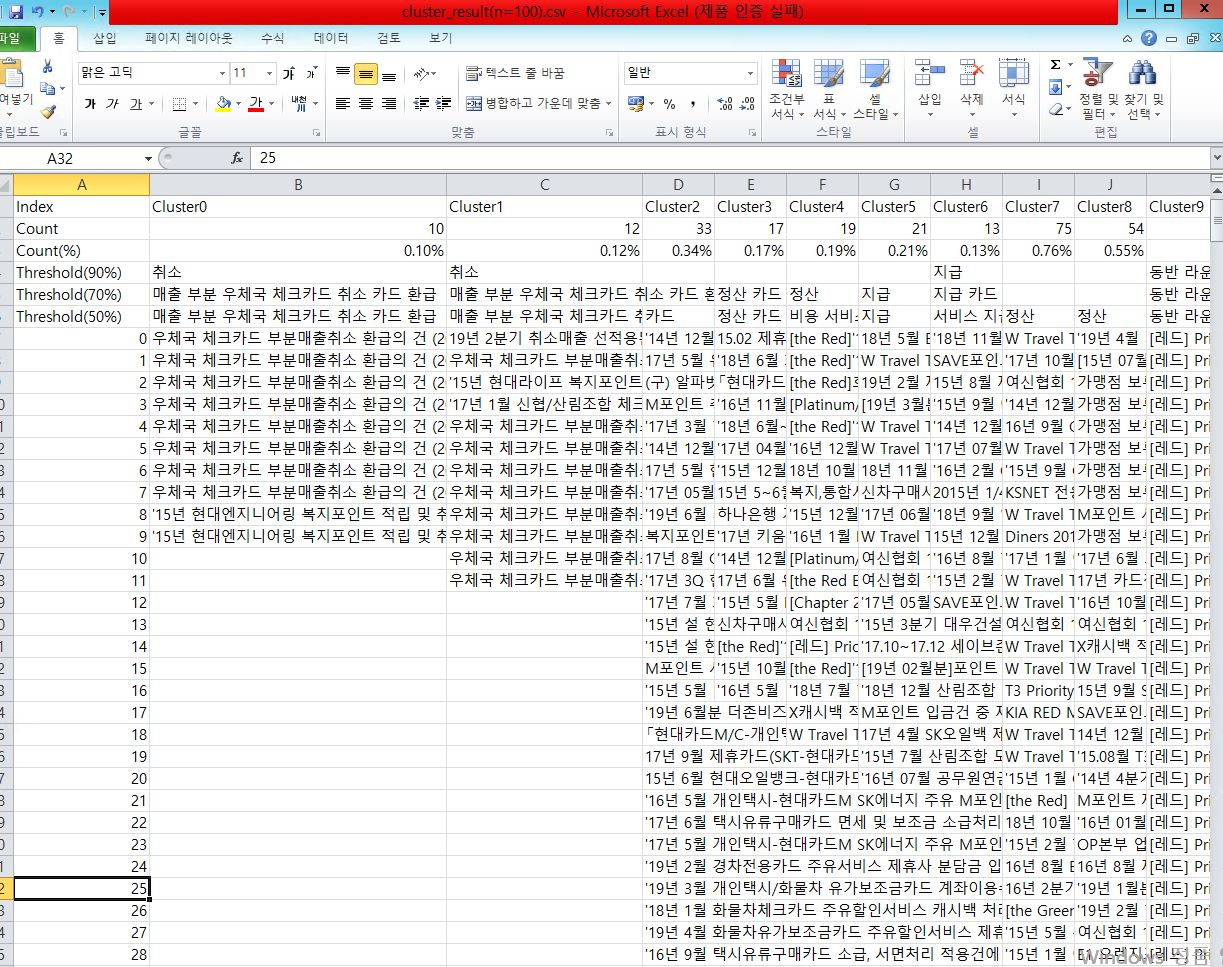

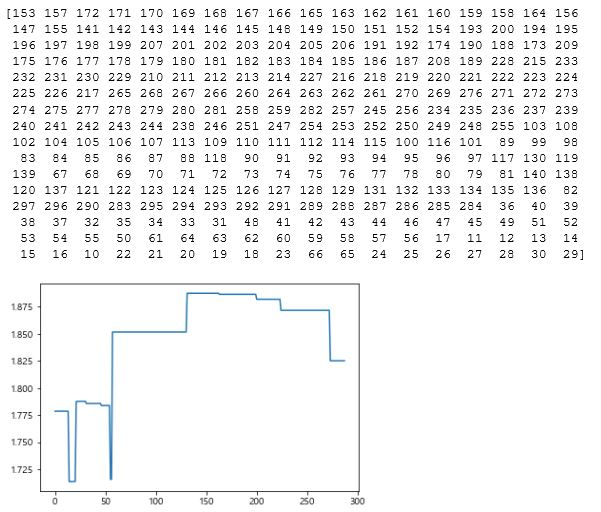

In [ ]:
### 이미지5
fig=plt.figure(figsize=(30,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.hist(silhouette_result[i])

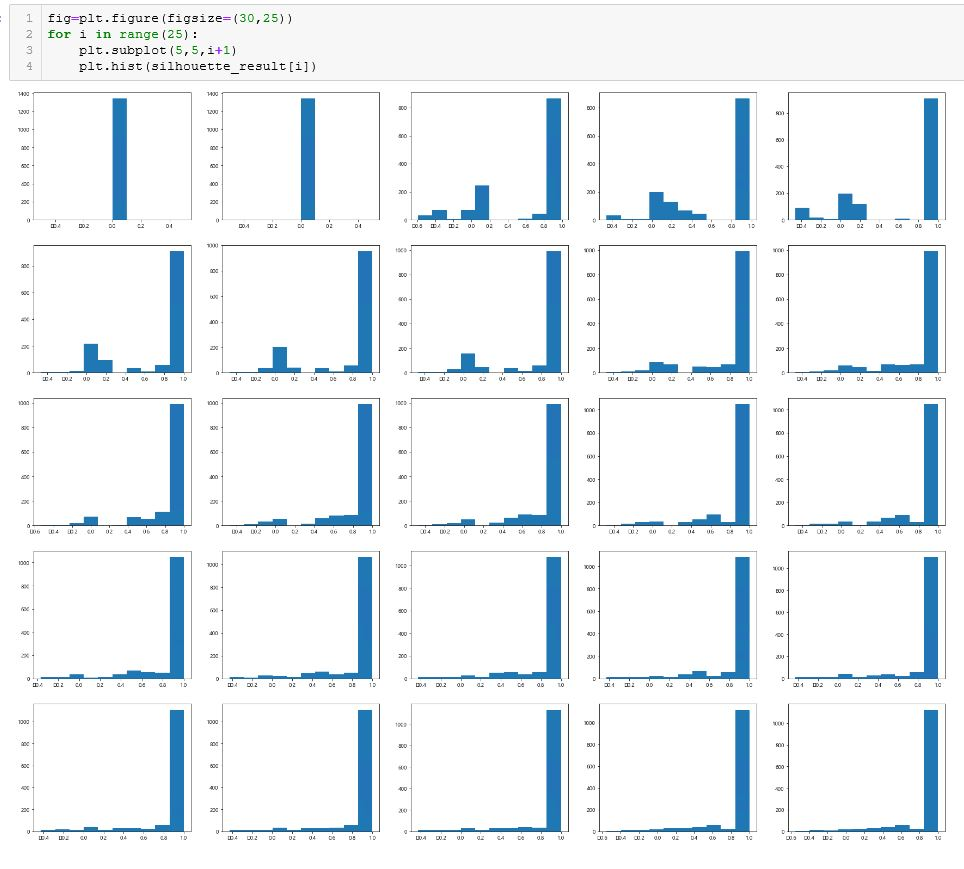

### 아래는 센텐스 클러스터링을 활용하여 할 수 있는 예시들 (제대로 클러스터링 되지 않은 것들 찾기)
### Finding Outliers (Documents that are not clustered anywhere)

In [ ]:
### 이미지6
# outlier1: 벡터상에 전부 0 값인 문서제목들 => 선별된 keyword들을 하나도 사용하지 않는 문서 제목
# outlier1: documents that have value of 0 -> documents whose keywords are never used
df_temp3.iloc[np.where(np.sum(freqMat,axis=1)==0)]

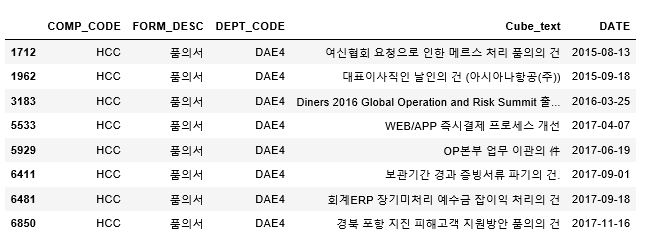

In [ ]:
### 이미지7
# silhouette 값이 0 이하인 문서제목들
# documents that have silhouette value less than 0
df_temp3.iloc[np.where(silhouette_vals<=0.0)]

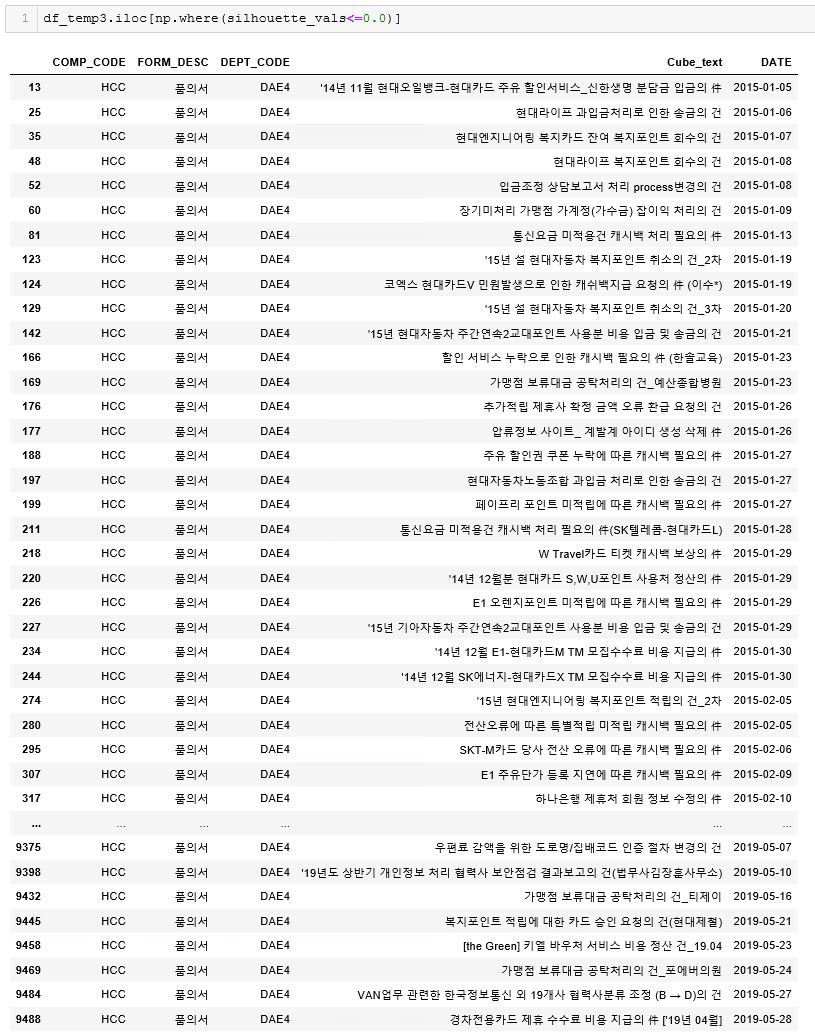